# Chapter 11 
 Industrial Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (2023) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

# Sampling Plans for Batch and Sequential Inspection

In [2]:
import random
import pandas as pd
import numpy as np
from scipy import stats, optimize
from scipy.special import gamma
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from mistat import acceptanceSampling
import mistat
import lifelines

In [3]:
from dataclasses import dataclass
from typing import List, Optional


## General Discussion

## Single-Stage Sampling Plans for Attributes

In [4]:
# note that scipy calls the pdf of discrete distributions pmf
j = [0, 1, 2, 3, 4]
print(pd.DataFrame({
    'j': j,
    'pdf': stats.hypergeom.pmf(j, M=100, n=10, N=5),
    'cdf': stats.hypergeom.cdf(j, M=100, n=10, N=5),
}).round(4))

j = [0, 1, 2, 3, 4, 5]
print(pd.DataFrame({
    'j': j,
    'pdf': stats.hypergeom.pmf(j, M=100, n=10, N=10),
    'cdf': stats.hypergeom.cdf(j, M=100, n=10, N=10),
}).round(4))

   j     pdf     cdf
0  0  0.5838  0.5838
1  1  0.3394  0.9231
2  2  0.0702  0.9934
3  3  0.0064  0.9997
4  4  0.0003  1.0000
   j     pdf     cdf
0  0  0.3305  0.3305
1  1  0.4080  0.7385
2  2  0.2015  0.9400
3  3  0.0518  0.9918
4  4  0.0076  0.9993
5  5  0.0006  1.0000


In [5]:
from mistat.acceptanceSampling import findPlan
findPlan(PRP=[0.01, 0.95], CRP=[0.08, 0.05], oc_type='hypergeom', N=100)

Plan(n=46, c=1, r=2)

In [6]:
p0 = np.array([*[0.01] * 10, *[0.03] * 10])
pt = np.linspace(0.05, 0.32, 10)
pt = np.array([*pt, *pt])

result = []
for p0i, pti in zip(p0, pt):
    result.append([p0i, pti, *findPlan(PRP=(p0i, 0.95), CRP=(pti, 0.05),
                   oc_type="hypergeom", N=100)])
result = pd.DataFrame(result, columns=['p0', 'pt', 'n', 'c', 'r'])

In [7]:
def latexTable(result):
    style = result.style.hide(axis='index')
    style = style.format(subset=['p0', 'pt'], precision=2)
    s = style.to_latex(hrules=True)
    s = s.replace('p0', '$p_0$').replace('pt', '$p_t$')
    s = s.replace(' n ', ' $n$ ').replace(' r ', ' $r$ ')
    return s.replace(' c ', ' $c$ ')

In [8]:
p0 = np.array([*[0.01] * 10, *[0.03] * 10])
pt = np.linspace(0.05, 0.32, 10)
pt = np.array([*pt, *pt])

result = []
for p0i, pti in zip(p0, pt):
    result.append([p0i, pti, *findPlan(PRP=(p0i, 0.90), CRP=(pti, 0.20),
                   oc_type="hypergeom", N=100)])
result = pd.DataFrame(result, columns=['p0', 'pt', 'n', 'c', 'r'])

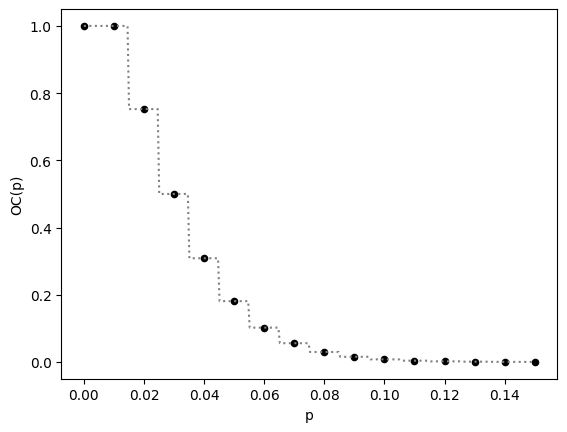

In [9]:
from mistat.acceptanceSampling import OperatingCharacteristics2c

X = OperatingCharacteristics2c(50, 1, oc_type='hypergeom', N=100,
                               pd=np.linspace(0, 0.15, 300))
df = pd.DataFrame({'p': X.pd, 'OC(p)': X.paccept})
ax = df.plot(x='p', y='OC(p)', legend=False, linestyle=':', color='grey')
ax.set_ylabel('OC(p)')

X = OperatingCharacteristics2c(50, 1, oc_type='hypergeom', N=100,
                               pd=[i / 100 for i in range(16)])
df = pd.DataFrame({'p': X.pd, 'OC(p)': X.paccept})
ax = df.plot.scatter(x='p', y='OC(p)', legend=False, ax=ax, color='black')
plt.show()

In [10]:
def latexTable(result):
    style = result.style.hide(axis='index')
    style = style.format(subset='p', precision=2)
    s = style.to_latex(column_format='cc', hrules=True)
    s = s.replace(' p ', ' $p$ ').replace('OC(p)', '$\mbox{OC}(p)$')
    return s

In [11]:
import math
# Note that the naming of the arguments follows the convention in scipy
# and therefore differs from the book
def normalApproximationOfH(j, M, n, N):
    P = N / M
    Q = 1 - P
    return stats.norm.cdf((j + 0.5 - n*P) / math.sqrt(n * P * Q * (1 - n/M)))

df0 = pd.DataFrame({
    'a': np.array(range(20)),
})
idx = [('', 'a')]
j = np.array(range(14))
df1 = pd.DataFrame({
    'H(j;100,30,20)': stats.hypergeom.cdf(j, M=100, n=20, N=30),
    'Normal': normalApproximationOfH(j, M=100, n=20, N=30),
})
idx.extend([('H(j;100,30,20)', 'Hypergeometric'), ('H(j;100,30,20)', 'Normal')])
j = np.array(range(18))
df2 = pd.DataFrame({
    'H(j;100,50,20)': stats.hypergeom.cdf(j, M=100, n=20, N=50),
    'Normal': normalApproximationOfH(j, M=100, n=20, N=50),
})
idx.extend([('H(j;100,50,20)', 'Hypergeometric'), ('H(j;100,50,20)', 'Normal')])
j = np.array(range(20))
df3 = pd.DataFrame({
    'H(j;100,80,20)': stats.hypergeom.cdf(j, M=100, n=20, N=80),
    'Normal': normalApproximationOfH(j, M=100, n=20, N=80),
})
idx.extend([('H(j;100,80,20)', 'Hypergeometric'), ('H(j;100,80,20)', 'Normal')])
df = pd.concat([df0, df1, df2, df3], axis=1)

df.columns = pd.MultiIndex.from_tuples(idx, names=["first", "second"])
style = df.style.hide(axis='index')
style = style.format(precision=4, na_rep='')
print(style.to_latex(hrules=True, column_format='ccccccc', multicol_align='c'))

\begin{tabular}{ccccccc}
\toprule
 & \multicolumn{2}{c}{H(j;100,30,20)} & \multicolumn{2}{c}{H(j;100,50,20)} & \multicolumn{2}{c}{H(j;100,80,20)} \\
a & Hypergeometric & Normal & Hypergeometric & Normal & Hypergeometric & Normal \\
\midrule
0 & 0.0003 & 0.0013 & 0.0000 & 0.0000 & 0.0000 & 0.0000 \\
1 & 0.0039 & 0.0070 & 0.0000 & 0.0000 & 0.0000 & 0.0000 \\
2 & 0.0227 & 0.0281 & 0.0000 & 0.0001 & 0.0000 & 0.0000 \\
3 & 0.0824 & 0.0863 & 0.0004 & 0.0006 & 0.0000 & 0.0000 \\
4 & 0.2092 & 0.2066 & 0.0025 & 0.0030 & 0.0000 & 0.0000 \\
5 & 0.4010 & 0.3925 & 0.0114 & 0.0122 & 0.0000 & 0.0000 \\
6 & 0.6151 & 0.6075 & 0.0392 & 0.0401 & 0.0000 & 0.0000 \\
7 & 0.7954 & 0.7934 & 0.1054 & 0.1056 & 0.0000 & 0.0000 \\
8 & 0.9115 & 0.9137 & 0.2270 & 0.2266 & 0.0000 & 0.0000 \\
9 & 0.9693 & 0.9719 & 0.4016 & 0.4013 & 0.0001 & 0.0000 \\
10 & 0.9915 & 0.9930 & 0.5984 & 0.5987 & 0.0006 & 0.0003 \\
11 & 0.9982 & 0.9987 & 0.7730 & 0.7734 & 0.0039 & 0.0025 \\
12 & 0.9997 & 0.9998 & 0.8946 & 0.8944 & 0.0181 &

## Approximate Determination of the Sampling Plan

In [12]:
from mistat.acceptanceSampling import findPlanApprox

def attainedRiskLevels(plan, p0, pt):
  hat_alpha = 1 - stats.hypergeom(N, int(p0 * N), plan.n).cdf(plan.c)
  hat_beta = stats.hypergeom(N, int(pt * N), plan.n).cdf(plan.c)
  return np.array([hat_alpha, hat_beta])

print('Exact results (p0=0.01, pt=0.03)')
for N in (500, 1000, 2000):
    plan = findPlan(PRP=[0.01, 0.95], CRP=[0.03, 0.05], oc_type='hypergeom', N=N)
    print(N, plan, attainedRiskLevels(plan, 0.01, 0.03).round(3))


print('Approximate results (p0=0.01, pt=0.03)')
for N in (500, 1000, 2000):
    plan = findPlanApprox(PRP=[0.01, 0.95], CRP=[0.03, 0.05], N=N)
    print(N, plan, attainedRiskLevels(plan, 0.01, 0.03).round(3))

print('Exact results (p0=0.01, pt=0.05)')
for N in (500, 1000, 2000):
    plan = findPlan(PRP=[0.01, 0.95], CRP=[0.05, 0.05], oc_type='hypergeom', N=N)
    print(N, plan, attainedRiskLevels(plan, 0.01, 0.05).round(3))

print('Approximate results (p0=0.01, pt=0.05)')
for N in (500, 1000, 2000):
    plan = findPlanApprox(PRP=[0.01, 0.95], CRP=[0.05, 0.05], N=N)
    print(N, plan, attainedRiskLevels(plan, 0.01, 0.05).round(3))

Exact results (p0=0.01, pt=0.03)


500 Plan(n=254, c=4, r=5) [0.033 0.05 ]


1000 Plan(n=355, c=6, r=7) [0.028 0.05 ]


2000 Plan(n=414, c=7, r=8) [0.038 0.049]
Approximate results (p0=0.01, pt=0.03)
500 Plan(n=248, c=4, r=5) [0.029 0.06 ]
1000 Plan(n=330, c=5, r=6) [0.072 0.036]
2000 Plan(n=396, c=6, r=7) [0.082 0.032]
Exact results (p0=0.01, pt=0.05)


500 Plan(n=139, c=3, r=4) [0.023 0.05 ]


1000 Plan(n=146, c=3, r=4) [0.045 0.049]


2000 Plan(n=176, c=4, r=5) [0.026 0.05 ]
Approximate results (p0=0.01, pt=0.05)
500 Plan(n=127, c=2, r=3) [0.107 0.026]
1000 Plan(n=146, c=3, r=4) [0.045 0.049]
2000 Plan(n=157, c=3, r=4) [0.066 0.037]


## Double-Sampling Plans for Attributes

In [13]:
def latexTable(df):
  style = pd.DataFrame(df).style.hide(axis='index')
  style = style.format(subset='p', precision=3)
  style = style.format(subset='OC', precision=4)
  style = style.format(subset='ASN', precision=1)
  s = style.to_latex(column_format='ccc', hrules=True)
  s = s.replace(' p &', ' $p$ &')
  s = s.replace('OC', 'OC($p$)')
  s = s.replace('ASN', 'ASN($p$)')
  return s
dsPlan = acceptanceSampling.DSPlanHypergeom(150, 20, 40, 2, 6, 6, p=np.arange(0, 0.525, 0.025))
df = pd.DataFrame({
  'p': dsPlan.p,
  'OC': dsPlan.OC,
  'ASN': dsPlan.ASN,
})

In [14]:
dsPlan = acceptanceSampling.DSPlanHypergeom(150, 20, 40, 1, 3, 3, p=np.arange(0, 0.525, 0.025))
df_stringent = pd.DataFrame({
  'p': dsPlan.p,
  'OC': dsPlan.OC,
  'ASN': dsPlan.ASN,
})

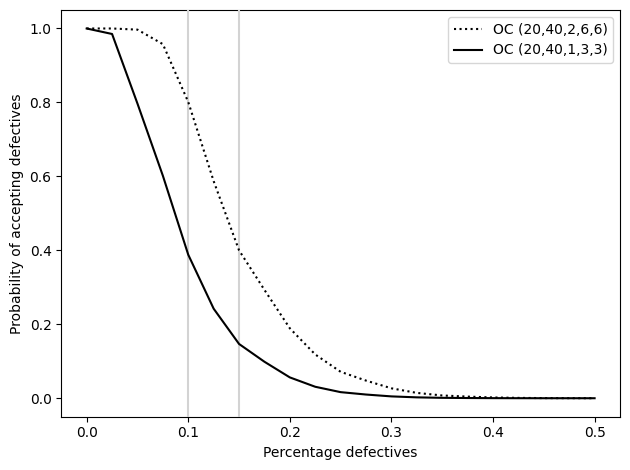

In [15]:
combined = pd.DataFrame({
    'p': df['p'],
    'OC (20,40,2,6,6)': df['OC'],
    'OC (20,40,1,3,3)': df_stringent['OC'],
})
ax = combined.plot(x='p', y='OC (20,40,2,6,6)', color='black', linestyle='dotted', zorder=10)
combined.plot(x='p', y='OC (20,40,1,3,3)', ax=ax, color='black', zorder=10)
ax.axvline(0.1, color='lightgray', zorder=5)
ax.axvline(0.15, color='lightgray', zorder=5)
ax.set_xlabel('Percentage defectives')
ax.set_ylabel('Probability of accepting defectives')
plt.tight_layout()

In [16]:
dsPlan = acceptanceSampling.DSPlanHypergeom(1000, 100, 200, 3, 6, 6, p=np.arange(0.01, 0.1, 0.01))
dsPlanApprox = acceptanceSampling.DSPlanNormal(1000, 100, 200, 3, 6, 6, p=np.arange(0.01, 0.1, 0.01))
df = pd.DataFrame({
  'p': dsPlan.p,
  'OC Exact': dsPlan.OC,
  'OC Approx.': dsPlanApprox.OC,
  'ASN Exact': dsPlan.ASN,
  'ASN Approx.': dsPlanApprox.ASN,
})
style = pd.DataFrame(df).style.hide(axis='index')
style = style.format(subset='p', precision=2)
style = style.format(subset=['OC Exact', 'OC Approx.'], precision=3)
style = style.format(subset=['ASN Exact', 'ASN Approx.'], precision=1)
s = style.to_latex(column_format='c|cc|cc', hrules=True)
s = s.replace(' p &', ' $p$ ak&')
s = s.replace('OC Exact', 'Exact')
s = s.replace('OC Approx.', 'Approx.')
s = s.replace('ASN Exact', 'Exact')
s = s.replace('ASN Approx.', 'Approx.')
s = s.replace(r'\toprule', r'\toprule & \multicolumn{2}{c|}{OC($p$)} & \multicolumn{2}{c}{ASN($p$)} \\')
print(s)

\begin{tabular}{c|cc|cc}
\toprule & \multicolumn{2}{c|}{OC($p$)} & \multicolumn{2}{c}{ASN($p$)} \\
p & Exact & Approx. & Exact & Approx. \\
\midrule
0.01 & 0.998 & 0.999 & 102.4 & 100.8 \\
0.02 & 0.897 & 0.896 & 124.1 & 125.0 \\
0.03 & 0.658 & 0.640 & 156.4 & 163.5 \\
0.04 & 0.421 & 0.401 & 175.6 & 179.2 \\
0.05 & 0.243 & 0.236 & 174.7 & 172.3 \\
0.06 & 0.130 & 0.134 & 160.6 & 155.7 \\
0.07 & 0.064 & 0.074 & 142.7 & 138.7 \\
0.08 & 0.030 & 0.040 & 127.1 & 125.1 \\
0.09 & 0.014 & 0.021 & 115.8 & 115.5 \\
\bottomrule
\end{tabular}



## Sequential Sampling and A/B testing

### The One-Armed Bernoulli Bandits

#### I.  The Bayesian Strategy

In [17]:
print(f'0.1-quantile B(10,0.6):  {stats.binom(10, 0.6).ppf(0.1)}')

0.1-quantile B(10,0.6):  4.0


In [18]:
print(f'B(5,7)-cdf :  {stats.beta(5, 7).cdf(0.5)}')

B(5,7)-cdf :  0.7255859375


In [19]:
print(f'B(5,8)-cdf :  {stats.beta(5, 8).cdf(0.5)}')

B(5,8)-cdf :  0.80615234375


In [20]:
np.random.seed(5)
print(f'{stats.binom(10, 0.3).rvs(1)} wins')

[2] wins


In [21]:
print(f'B(3,9)-cdf :  {stats.beta(3, 9).cdf(0.5)}')

B(3,9)-cdf :  0.96728515625


In [22]:
np.random.seed(1)

N=50; lambda_=0.5; k0=10; gamma=0.95; Ns=1000

results = []
for p in (0.4, 0.45, 0.5, 0.55, 0.6, 0.7):
  r = acceptanceSampling.simulateOAB(N, p, lambda_, k0, gamma, Ns)
  results.append({
      'p': p,
      'Mgamma_mean': r.mgamma.mean,
      'Mgamma_std': r.mgamma.std,
      'Reward_mean': r.reward.mean,
      'Reward_std': r.reward.std,
  })

In [23]:
style = pd.DataFrame(results).style.hide(axis='index')
style = style.format(precision=3)
style = style.format(subset='p', precision=2)
s = style.to_latex(column_format='ccccc', hrules=True)
s = s.replace(' p &', ' $p$ &')
s = s.replace('Mgamma_mean', '$E\\{M_{\gamma}\\}$')
s = s.replace('Mgamma_std', '$\\text{std}\\{M_{\gamma}\\}$')
s = s.replace('Reward_mean', '$E\\{\\text{Reward}\\}$')
s = s.replace('Reward_std', '$\\text{std}\\{\\text{Reward}\\}$')
print(s)

\begin{tabular}{ccccc}
\toprule
p & $E\{M_{\gamma}\}$ & $\text{std}\{M_{\gamma}\}$ & $E\{\text{Reward}\}$ & $\text{std}\{\text{Reward}\}$ \\
\midrule
0.40 & 31.631 & 16.938 & 21.950 & 2.016 \\
0.45 & 39.078 & 15.676 & 23.352 & 2.882 \\
0.50 & 44.359 & 12.756 & 25.360 & 3.395 \\
0.55 & 46.846 & 9.910 & 27.637 & 3.738 \\
0.60 & 49.013 & 5.791 & 30.404 & 3.665 \\
0.70 & 49.882 & 2.152 & 35.753 & 3.251 \\
\bottomrule
\end{tabular}



In [24]:
from mistat.acceptanceSampling import optimalOAB
result = optimalOAB(10, 0.5)
print(f'Case (10, 0.5): {result.max_reward:.3f}')
print(f'Case (50, 0.5): {optimalOAB(50, 0.5).max_reward:.3f}')

Case (10, 0.5): 7.912
Case (50, 0.5): 40.175


In [25]:
table = pd.DataFrame(result.rewards)
table.index.name = 'n'
width = table.shape[1]
for i in range(1, len(table)):
  table.iloc[i, width-i:] = np.nan
style = table.style
style = style.format(precision=3, na_rep='')
s = style.to_latex(hrules=True)
print(s)

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\
n &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
0 & 0.500 & 0.500 & 0.500 & 0.500 & 0.500 & 0.545 & 0.636 & 0.727 & 0.818 & 0.909 & 1.000 \\
1 & 1.000 & 1.000 & 1.000 & 1.000 & 1.023 & 1.200 & 1.400 & 1.600 & 1.800 & 2.000 &  \\
2 & 1.500 & 1.500 & 1.500 & 1.500 & 1.677 & 2.000 & 2.333 & 2.667 & 3.000 &  &  \\
3 & 2.000 & 2.000 & 2.000 & 2.088 & 2.504 & 3.000 & 3.500 & 4.000 &  &  &  \\
4 & 2.500 & 2.500 & 2.500 & 2.897 & 3.573 & 4.286 & 5.000 &  &  &  &  \\
5 & 3.000 & 3.000 & 3.199 & 4.014 & 5.000 & 6.000 &  &  &  &  &  \\
6 & 3.500 & 3.500 & 4.288 & 5.603 & 7.000 &  &  &  &  &  &  \\
7 & 4.000 & 4.394 & 6.024 & 8.000 &  &  &  &  &  &  &  \\
8 & 4.500 & 6.147 & 9.000 &  &  &  &  &  &  &  &  \\
9 & 5.824 & 10.000 &  &  &  &  &  &  &  &  &  \\
\bottomrule
\end{tabular}



### Two-Armed Bernoulli Bandits

In [26]:
optimalOAB(45, 0.143).max_reward

33.870065529505496

## Acceptance Sampling Plans for Variables

## Rectifying Inspection of Lots

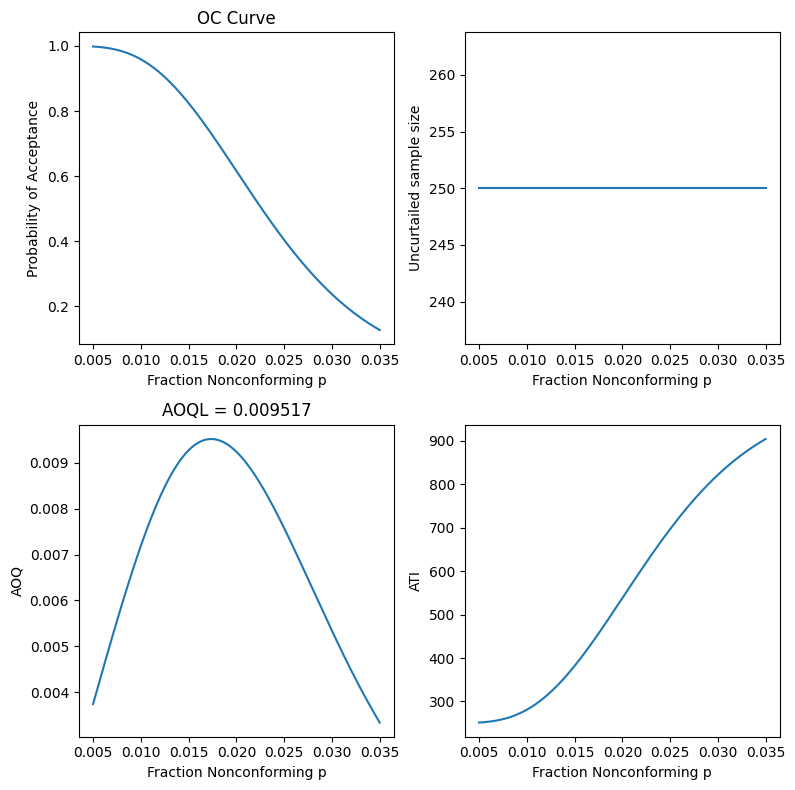

In [27]:
from mistat.acceptanceSampling import SSPlanBinomial
plan = SSPlanBinomial(N=1000, n=250, Ac=5,
                      p=np.linspace(0.005, 0.035, 200))
plan.plot()
plt.tight_layout()

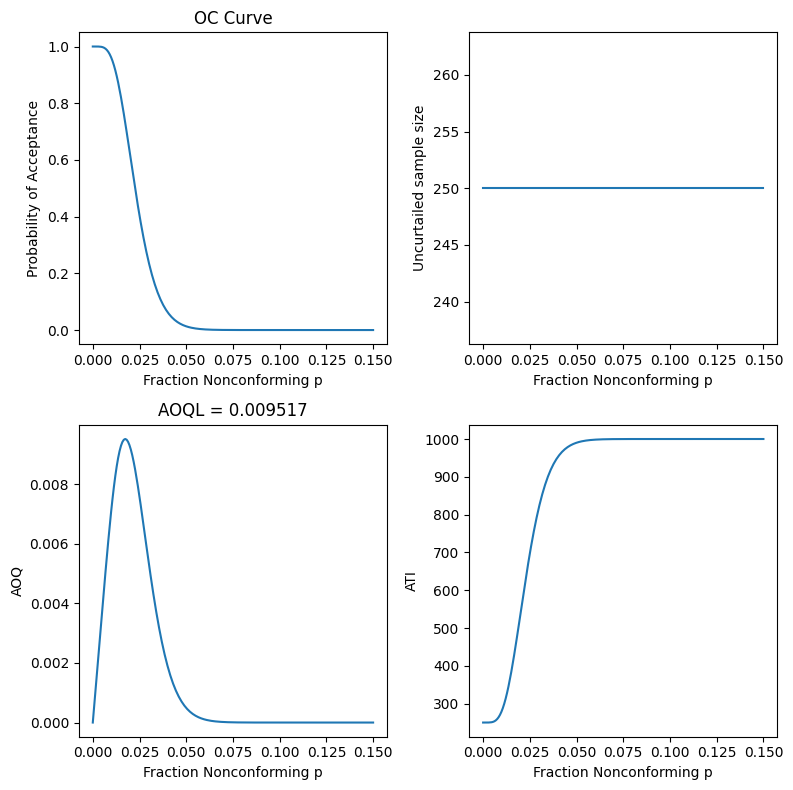

In [28]:
plan = SSPlanBinomial(N=1000, n=250, Ac=5,
                      p=np.linspace(0.0, 0.15, 200))
plan.plot()
plt.tight_layout()

## National and International Standards

In [29]:
plan = acceptanceSampling.SSPlanBinomial(1000, 80, 2,
                                         p=(0.01, 0.02, 0.03, 0.04, 0.05))

## Skip-Lot Sampling Plans for Attributes

### The ISO 2859 Skip-Lot Sampling Procedures

#### Skip Lot Switching Rules

## The Deming Inspection Criterion

## Published Tables for Acceptance Sampling

#### I.  

#### II.  

## Sequential Reliability Testing

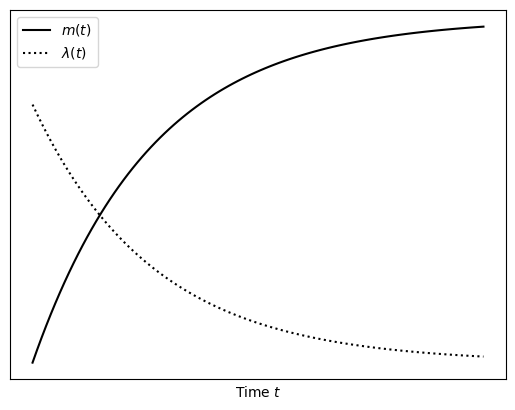

In [30]:
# use Goel-Okumoto model as the example
a = 1
b = 0.75

t = np.linspace(0, 5, 100)

curves = pd.DataFrame({
    't': t,
    'm(t)':  a * (1 - np.exp(-b*t)),
    'lambda(t)': a * b * np.exp(-b*t),
})
ax = curves.plot(x='t', y='m(t)', color='black', label='$m(t)$')
curves.plot(x='t', y='lambda(t)', ax=ax, color='black', linestyle=':', label='$\lambda(t)$')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_xlabel('Time $t$')
plt.show()

In [31]:
def GoelOkumoto(t, a, b):
    return a * (1 - np.exp(-b * t))

def Yamada(t, a, b):
    return a * (1 - (1+b*t)*np.exp(-b*t))

In [32]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [33]:
def optimizeModelFit(model, data):
    fit = optimize.curve_fit(model, data['T'], data['CFC'])
    popt = fit[0]
    # add the fit to the dataset
    data[model.__name__] = [model(t, *popt) for t in data['T']]
    return popt

data = mistat.load_data('FAILURE_J3')
goFit = optimizeModelFit(GoelOkumoto, data)
ohbaFit = optimizeModelFit(Yamada, data)

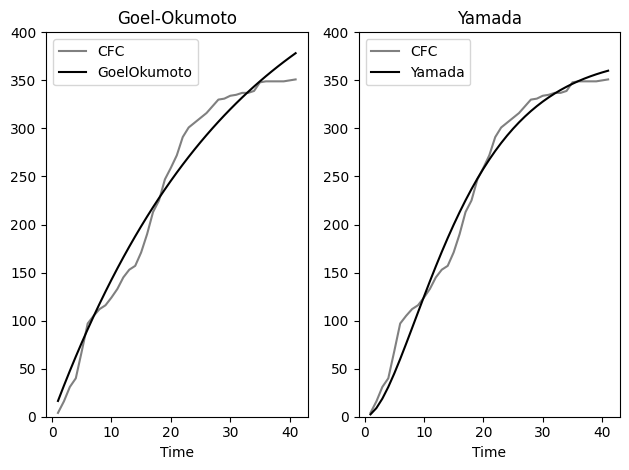

In [34]:
fig, axes = plt.subplots(ncols=2)
data.plot(x='T', y='CFC', color='grey', ax=axes[0])
data.plot(x='T', y='GoelOkumoto', color='black', ax=axes[0])
axes[0].set_title('Goel-Okumoto')
axes[0].set_xlabel('Cumulative failure count')
axes[0].set_xlabel('Time')
axes[0].set_ylim(0, 400)
data.plot(x='T', y='CFC', color='grey', ax=axes[1])
data.plot(x='T', y='Yamada', color='black', ax=axes[1])
axes[1].set_title('Yamada')
axes[1].set_xlabel('Time')
axes[1].set_ylim(0, 400)
plt.tight_layout()
plt.show()

## Chapter Highlights

## Exercises